In [ ]:
!pip install graphviz

In [ ]:
def extract_sql_and_physical_plan(file_path):
    result = []
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    
    # Split the content by the separator
    entries = content.split('------------------------------------------------------------------------------------------------------------------')

    for entry in entries:
        current_entry = {}
        capture_mode = None
        buffer = []
        
        lines = entry.splitlines()
        
        for line in lines:
            stripped_line = line.strip()

            if stripped_line.startswith("[SQL Query]"):
                # Save previous entry if complete
                if 'SQL Query' in current_entry and 'Physical plan' in current_entry:
                    result.append(current_entry)
                current_entry = {}
                capture_mode = 'SQL Query'
                buffer = []
                continue
            elif stripped_line.startswith("[Physical plan]"):
                if capture_mode and buffer:
                    current_entry[capture_mode] = '\n'.join(buffer).strip()
                capture_mode = 'Physical plan'
                buffer = []
                continue
            elif stripped_line.startswith("[") and stripped_line.endswith("]"):
                # Save current buffer if switching to a new section
                if capture_mode and buffer:
                    current_entry[capture_mode] = '\n'.join(buffer).strip()
                capture_mode = None
                buffer = []
                continue
            
            if capture_mode:
                buffer.append(line.rstrip())

        # Catch the last entry if needed
        if capture_mode and buffer:
            current_entry[capture_mode] = '\n'.join(buffer).strip()
        if 'SQL Query' in current_entry and 'Physical plan' in current_entry:
            result.append(current_entry)

    return result


In [ ]:
file_path = 'physical_plans.txt'
data = extract_sql_and_physical_plan(file_path)

for entry in data:
    print("SQL Query:\n", entry['SQL Query'])
    print("Physical plan:\n", entry['Physical plan'])
    print('-' * 80)

In [8]:
import re
from typing import List, Dict
from dataclasses import dataclass, field

@dataclass
class PlanNode:
    op_type: str
    attributes: Dict[str, str]
    node_id: int
    children: List["PlanNode"] = field(default_factory=list)

def parse_plan(plan_text: str) -> PlanNode:
    lines = [line.rstrip() for line in plan_text.strip().split("\n") if line.strip()]
    stack: List[Tuple[int, PlanNode]] = []

    node_pattern = re.compile(r"(\w+)\((.*?)\), id\s*=\s*(\d+)")
    attr_pattern = re.compile(r"(\w+)=\[(.*?)\]")

    for line in lines:
        indent = len(line) - len(line.lstrip())
        match = node_pattern.match(line.strip())
        if not match:
            continue

        op_type, raw_attrs, node_id = match.groups()
        node_id = int(node_id)

        # Parse attributes
        attributes = {k: v for k, v in attr_pattern.findall(raw_attrs)}

        node = PlanNode(op_type, attributes, node_id)

        # Attach to parent
        while stack and stack[-1][0] >= indent:
            stack.pop()
        if stack:
            stack[-1][1].children.append(node)

        stack.append((indent, node))

    # Root node is the first one in the stack
    return stack[0][1] if stack else None


In [ ]:
with open("outputs.txt") as f:
    text = f.read()

# Split on physical plan sections
plans = text.split("Physical plan:")
for plan_text in plans[1:]:
    root = parse_plan(plan_text)
    print(root)


In [12]:
from graphviz import Digraph
from typing import Optional
import html

def escape_label(s):
    return html.escape(str(s))

def visualize_plan_tree(root: PlanNode, filename: Optional[str] = "plan_tree") -> Digraph:
    dot = Digraph(format='png')
    dot.attr(rankdir='TB')  # Top to bottom

    def add_nodes_edges(node: PlanNode):
        node_label = f"{node.op_type}\\n(id={node.node_id})"
        for k, v in node.attributes.items():
            node_label += f"\\n{k}=[{v}]"
        node_label = escape_label(node_label)
        dot.node(str(node.node_id), label=node_label, shape="box", style="filled", fillcolor="lightgray")

        for child in node.children:
            dot.edge(str(node.node_id), str(child.node_id))
            add_nodes_edges(child)

    add_nodes_edges(root)
    dot.render(filename, view=True)
    return dot


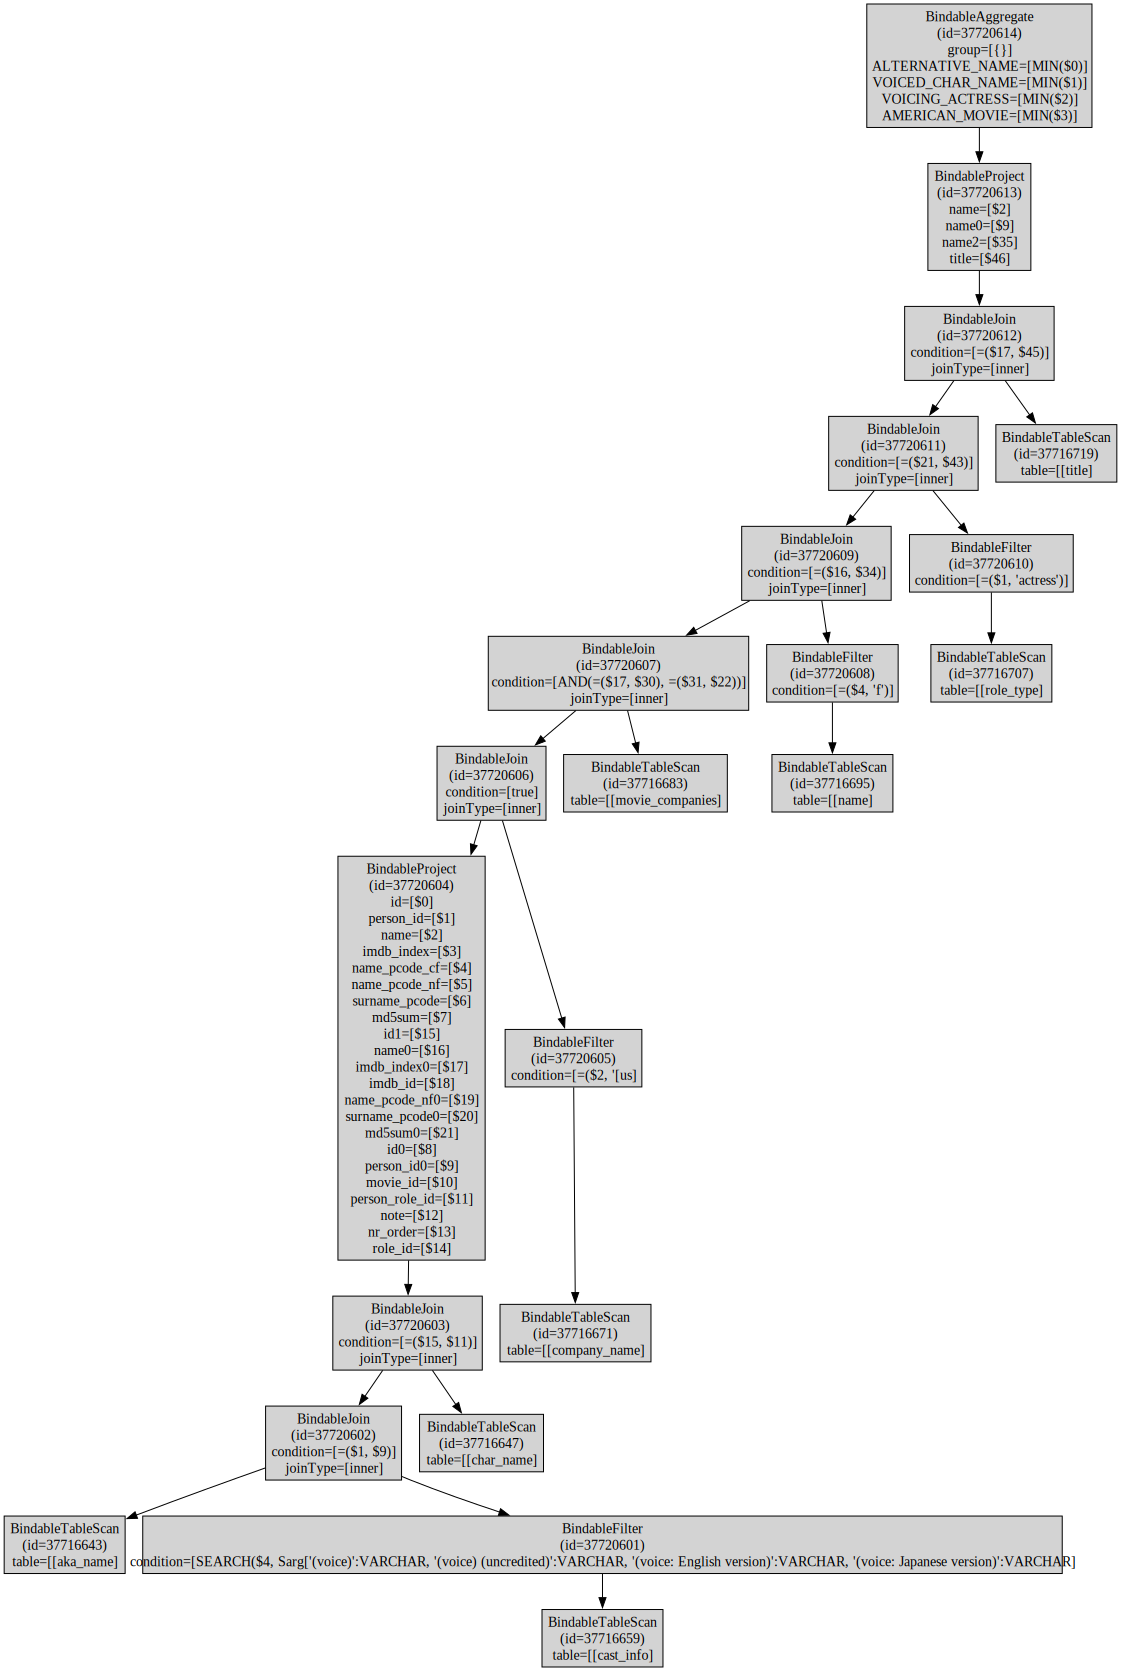

In [14]:
root_node = parse_plan("""BindableAggregate(group=[{}], ALTERNATIVE_NAME=[MIN($0)], VOICED_CHAR_NAME=[MIN($1)], VOICING_ACTRESS=[MIN($2)], AMERICAN_MOVIE=[MIN($3)]), id = 37720614
  BindableProject(name=[$2], name0=[$9], name2=[$35], title=[$46]), id = 37720613
    BindableJoin(condition=[=($17, $45)], joinType=[inner]), id = 37720612
      BindableJoin(condition=[=($21, $43)], joinType=[inner]), id = 37720611
        BindableJoin(condition=[=($16, $34)], joinType=[inner]), id = 37720609
          BindableJoin(condition=[AND(=($17, $30), =($31, $22))], joinType=[inner]), id = 37720607
            BindableJoin(condition=[true], joinType=[inner]), id = 37720606
              BindableProject(id=[$0], person_id=[$1], name=[$2], imdb_index=[$3], name_pcode_cf=[$4], name_pcode_nf=[$5], surname_pcode=[$6], md5sum=[$7], id1=[$15], name0=[$16], imdb_index0=[$17], imdb_id=[$18], name_pcode_nf0=[$19], surname_pcode0=[$20], md5sum0=[$21], id0=[$8], person_id0=[$9], movie_id=[$10], person_role_id=[$11], note=[$12], nr_order=[$13], role_id=[$14]), id = 37720604
                BindableJoin(condition=[=($15, $11)], joinType=[inner]), id = 37720603
                  BindableJoin(condition=[=($1, $9)], joinType=[inner]), id = 37720602
                    BindableTableScan(table=[[aka_name]]), id = 37716643
                    BindableFilter(condition=[SEARCH($4, Sarg['(voice)':VARCHAR, '(voice) (uncredited)':VARCHAR, '(voice: English version)':VARCHAR, '(voice: Japanese version)':VARCHAR]:VARCHAR)]), id = 37720601
                      BindableTableScan(table=[[cast_info]]), id = 37716659
                  BindableTableScan(table=[[char_name]]), id = 37716647
              BindableFilter(condition=[=($2, '[us]')]), id = 37720605
                BindableTableScan(table=[[company_name]]), id = 37716671
            BindableTableScan(table=[[movie_companies]]), id = 37716683
          BindableFilter(condition=[=($4, 'f')]), id = 37720608
            BindableTableScan(table=[[name]]), id = 37716695
        BindableFilter(condition=[=($1, 'actress')]), id = 37720610
          BindableTableScan(table=[[role_type]]), id = 37716707
      BindableTableScan(table=[[title]]), id = 37716719
""")
root_node
visualize_plan_tree(root_node, filename="example_plan")

In [20]:
from typing import Dict, List
from io import StringIO

class PlanCodeGenerator:
    def __init__(self, root):
        self.root = root
        self.code_lines = []
        self.visited = set()

    def generate(self) -> str:
        self.code_lines = [
            "import pandas as pd",
            "# Load CSVs (you may need to adjust paths)",
        ]
        self._gen_node_code(self.root)
        self.code_lines.append(f"\nresult = df_{self.root.node_id}")
        self.code_lines.append("print(result.head())")
        return "\n".join(self.code_lines)

    def _gen_node_code(self, node):
        if node.node_id in self.visited:
            return
        self.visited.add(node.node_id)

        # Generate code for children first
        for child in node.children:
            self._gen_node_code(child)

        op = node.op_type
        df_name = f"df_{node.node_id}"

        if op == "BindableTableScan":
            table = self._extract_table_name(node.attributes.get("table", ""))
            self.code_lines.append(f"{df_name} = pd.read_csv('{table}.csv')")

        elif op == "BindableFilter":
            child_df = f"df_{node.children[0].node_id}"
            condition = self._translate_condition(node.attributes.get("condition", ""))
            self.code_lines.append(f"{df_name} = {child_df}.query({condition})")

        elif op == "BindableProject":
            child_df = f"df_{node.children[0].node_id}"
            cols = self._extract_projection_cols(node.attributes)
            self.code_lines.append(f"{df_name} = {child_df}[[{', '.join(cols)}]]")

        elif op == "BindableJoin":
            left = f"df_{node.children[0].node_id}"
            right = f"df_{node.children[1].node_id}"
            join_type = node.attributes.get("joinType", "inner").strip('[]')
            on_cols = self._translate_join_condition(node.attributes.get("condition", ""))
            self.code_lines.append(f"{df_name} = pd.merge({left}, {right}, how='{join_type}', {on_cols})")

        elif op == "BindableAggregate":
            child_df = f"df_{node.children[0].node_id}"
            aggs = self._translate_aggregates(node.attributes)
            self.code_lines.append(f"{df_name} = {child_df}.agg({aggs}).reset_index(drop=True)")

        elif op == "BindableValues":
            self.code_lines.append(f"{df_name} = pd.DataFrame([[]])")

        else:
            self.code_lines.append(f"# Unsupported node type: {op}")
            self.code_lines.append(f"{df_name} = pd.DataFrame()  # placeholder")

    def _extract_table_name(self, table_attr):
        # table=[[movie_companies]] => movie_companies
        return table_attr.replace("[[", "").replace("]]", "").split(".")[-1]

    def _extract_projection_cols(self, attrs: Dict[str, str]) -> List[str]:
        # Extract projection columns like name=[$1], title=[$2] -> return ['"name"', '"title"']
        return [f"'{k}'" for k in attrs.keys()]

    def _translate_condition(self, cond: str) -> str:
        # Minimal translator for now; could be improved with regex parsing
        cond = cond.replace("LIKE", "str.contains")
        cond = cond.replace("AND", "and").replace("OR", "or")
        cond = cond.replace("=", "==")
        cond = cond.replace("<>", "!=")
        cond = cond.replace("true", "True").replace("false", "False")
        return f'""" {cond} """'

    def _translate_join_condition(self, cond: str) -> str:
        # Example: =($0, $1) => on=['col0', 'col1']
        matches = re.findall(r"\$([0-9]+)", cond)
        if len(matches) == 2:
            return f"left_on='col{matches[0]}', right_on='col{matches[1]}'"
        elif "AND" in cond:
            cols = re.findall(r"\$([0-9]+)", cond)
            return f"left_on={[f'col{c}' for c in cols[::2]]}, right_on={[f'col{c}' for c in cols[1::2]]}"
        else:
            return "# TODO: Complex join condition"

    def _translate_aggregates(self, attrs: Dict[str, str]) -> str:
        agg_map = {}
        for k, v in attrs.items():
            match = re.search(r'MIN\(\$(\d+)\)', v)
            if match:
                col = f"col{match.group(1)}"
                agg_map[k.lower()] = f"('{col}', 'min')"
            # You can add other aggregate support here (e.g. MAX, SUM, etc.)
    
        return "{" + ", ".join(f"'{k}': {v}" for k, v in agg_map.items()) + "}"


In [22]:
plan_text = """BindableAggregate(group=[{}], ALTERNATIVE_NAME=[MIN($0)], VOICED_CHAR_NAME=[MIN($1)], VOICING_ACTRESS=[MIN($2)], AMERICAN_MOVIE=[MIN($3)]), id = 37720614
  BindableProject(name=[$2], name0=[$9], name2=[$35], title=[$46]), id = 37720613
    BindableJoin(condition=[=($17, $45)], joinType=[inner]), id = 37720612
      BindableJoin(condition=[=($21, $43)], joinType=[inner]), id = 37720611
        BindableJoin(condition=[=($16, $34)], joinType=[inner]), id = 37720609
          BindableJoin(condition=[AND(=($17, $30), =($31, $22))], joinType=[inner]), id = 37720607
            BindableJoin(condition=[true], joinType=[inner]), id = 37720606
              BindableProject(id=[$0], person_id=[$1], name=[$2], imdb_index=[$3], name_pcode_cf=[$4], name_pcode_nf=[$5], surname_pcode=[$6], md5sum=[$7], id1=[$15], name0=[$16], imdb_index0=[$17], imdb_id=[$18], name_pcode_nf0=[$19], surname_pcode0=[$20], md5sum0=[$21], id0=[$8], person_id0=[$9], movie_id=[$10], person_role_id=[$11], note=[$12], nr_order=[$13], role_id=[$14]), id = 37720604
                BindableJoin(condition=[=($15, $11)], joinType=[inner]), id = 37720603
                  BindableJoin(condition=[=($1, $9)], joinType=[inner]), id = 37720602
                    BindableTableScan(table=[[aka_name]]), id = 37716643
                    BindableFilter(condition=[SEARCH($4, Sarg['(voice)':VARCHAR, '(voice) (uncredited)':VARCHAR, '(voice: English version)':VARCHAR, '(voice: Japanese version)':VARCHAR]:VARCHAR)]), id = 37720601
                      BindableTableScan(table=[[cast_info]]), id = 37716659
                  BindableTableScan(table=[[char_name]]), id = 37716647
              BindableFilter(condition=[=($2, '[us]')]), id = 37720605
                BindableTableScan(table=[[company_name]]), id = 37716671
            BindableTableScan(table=[[movie_companies]]), id = 37716683
          BindableFilter(condition=[=($4, 'f')]), id = 37720608
            BindableTableScan(table=[[name]]), id = 37716695
        BindableFilter(condition=[=($1, 'actress')]), id = 37720610
          BindableTableScan(table=[[role_type]]), id = 37716707
      BindableTableScan(table=[[title]]), id = 37716719"""
root = parse_plan(plan_text)
generator = PlanCodeGenerator(root)
code = generator.generate()

print(code)

import pandas as pd
# Load CSVs (you may need to adjust paths)
df_37716643 = pd.read_csv('[aka_name.csv')
df_37716659 = pd.read_csv('[cast_info.csv')
df_37720601 = df_37716659.query(""" SEARCH($4, Sarg['(voice)':VARCHAR, '(voice) (uncredited)':VARCHAR, '(voice: English version)':VARCHAR, '(voice: Japanese version)':VARCHAR """)
df_37720602 = pd.merge(df_37716643, df_37720601, how='inner', left_on='col1', right_on='col9')
df_37716647 = pd.read_csv('[char_name.csv')
df_37720603 = pd.merge(df_37720602, df_37716647, how='inner', left_on='col15', right_on='col11')
df_37720604 = df_37720603[['id', 'person_id', 'name', 'imdb_index', 'name_pcode_cf', 'name_pcode_nf', 'surname_pcode', 'md5sum', 'id1', 'name0', 'imdb_index0', 'imdb_id', 'name_pcode_nf0', 'surname_pcode0', 'md5sum0', 'id0', 'person_id0', 'movie_id', 'person_role_id', 'note', 'nr_order', 'role_id']]
df_37716671 = pd.read_csv('[company_name.csv')
df_37720605 = df_37716671.query(""" ==($2, '[us """)
df_37720606 = pd.merge(df_3772060